#  Lane Finding: Project 4

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import image_class as ic
import line_class as lc
%matplotlib inline

In [2]:
 
paths = glob.glob('test_images/test*')
test_images = []
for path in paths:
    f = mpimg.imread(path)
    img = ic.ImageClass(f)
    test_images.append(img)
    
# Load saved calibration variables
with open('calibration.pickle', 'rb') as f:  
    ret, mtx, dist, rvecs, tvecs = pickle.load(f)
    


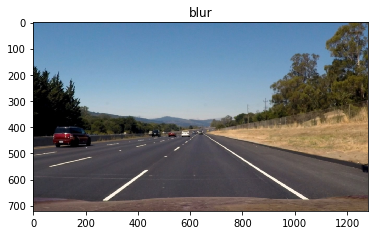

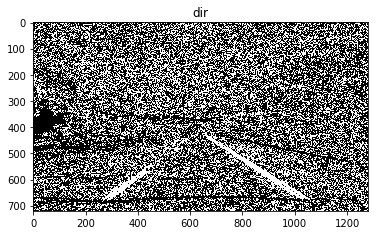

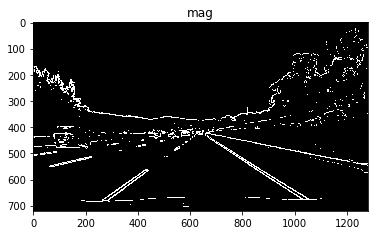

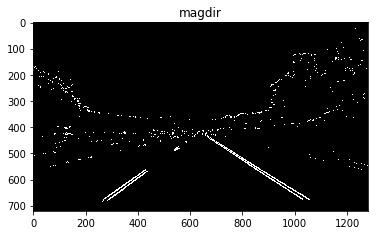

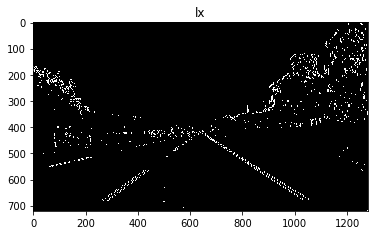

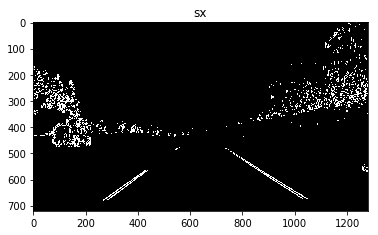

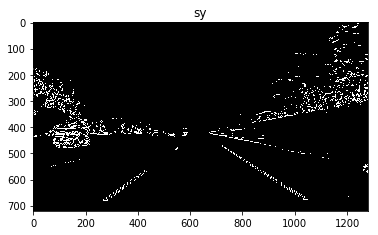

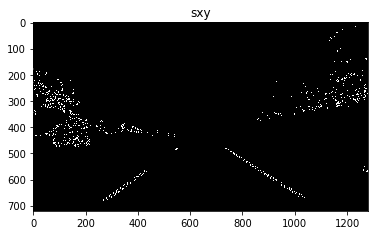

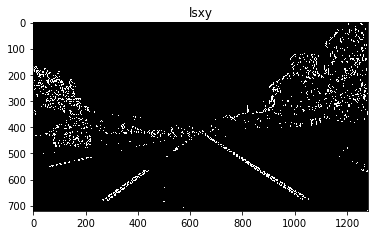

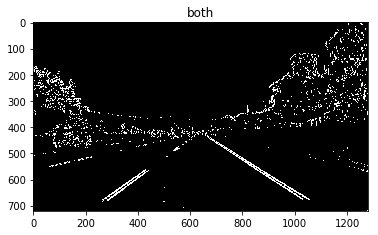

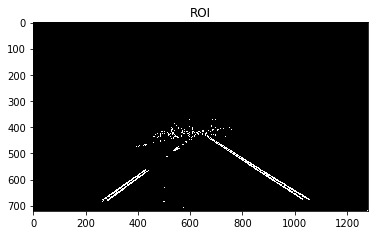

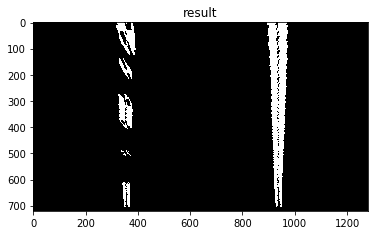

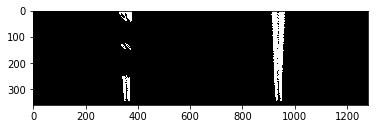

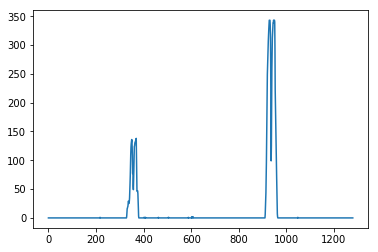

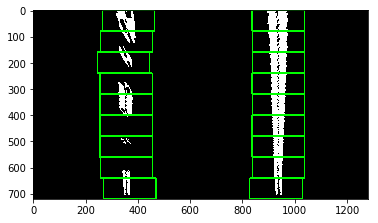

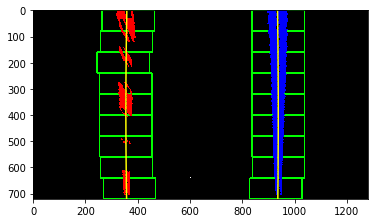

In [3]:
im1, Minv = test_images[6].binary_warp(visualize=True)
left_fit1, right_fit1, leftx1, rightx1, lefty1, righty1= im1.find_lines(visualize=True)




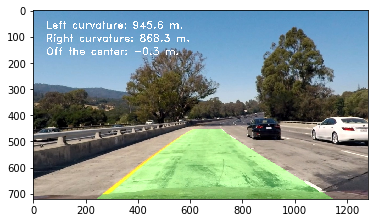

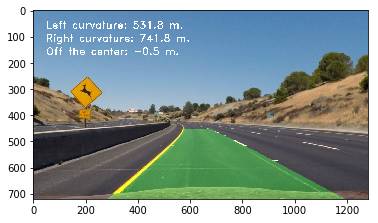

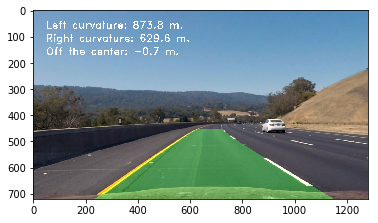

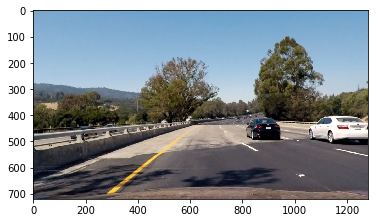

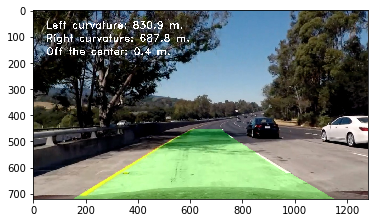

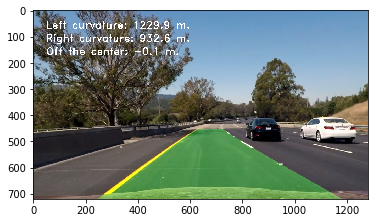

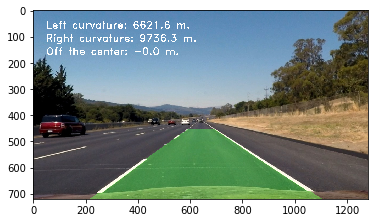

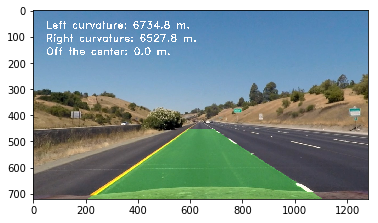

In [4]:
def pipeline(img, l_line, r_line, mtx, dist):
    #convert to image class
    img = ic.ImageClass(img, 'rgb')
    undist = img.undistort(mtx, dist)
    n_lines = 15
    ploty = np.linspace(0, 719, num=720)
    #convert to binary top down view of the lane lines
    #all Sobel and other image transforming opporations are found in this function
    binary, Minv = img.binary_warp(visualize=False)
    
    if r_line.detected and l_line.detected:
        left_fit, right_fit, leftx, rightx, lefty, righty = binary.find_lines_with_lines(l_line.best_fit, r_line.best_fit, margin=100, visualize=False)
        leftcurv, rightcurv = l_line.get_radius(r_line, left_fit, right_fit)
    
        r_line.update_fit(right_fit, rightx, righty, n_lines)
        l_line.update_fit(left_fit, leftx, lefty, n_lines)
        
    else:
        left_fit, right_fit, leftx, rightx, lefty, righty = binary.find_lines(margin=100, minpix=300, visualize=False)
        leftcurv, rightcurv = l_line.get_radius(r_line, left_fit, right_fit)

        r_line.update_fit(right_fit, rightx, righty, n_lines)
        l_line.update_fit(left_fit, leftx, lefty, n_lines)
            
            
    if r_line.detected and l_line.detected:
        warped = binary
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        left_fit = l_line.best_fit
        right_fit = r_line.best_fit

        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.img.shape[1], img.img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist.img, 1, newwarp, 0.3, 0)
        
        position = l_line.line_base_pos + r_line.line_base_pos
        
        cv2.putText(result, "Left curvature: %.1f m." % leftcurv, (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
        cv2.putText(result, "Right curvature: %.1f m." % rightcurv, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
        cv2.putText(result, "Off the center: %.1f m." % position, (50, 170), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
        return result
    else:
        return undist.img

for img in test_images:
    l_line = lc.Line()
    r_line = lc.Line()
    result = pipeline(img.img, l_line, r_line, mtx,dist)
    plt.figure()
    plt.imshow(result)

In [5]:
from moviepy.editor import VideoFileClip

In [6]:
def process_image(image):
    image = pipeline(image, l_line, r_line, mtx, dist)
    return image
    

In [7]:
project_output = 'test_videos_output/project.mp4'
l_line = lc.Line()
r_line = lc.Line()
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project.mp4
[MoviePy] Writing video test_videos_output/project.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:04<00:00,  4.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project.mp4 

Wall time: 5min 4s
